<a href="https://colab.research.google.com/github/Mouhsine22/Houses-sales-forecasting/blob/main/Machine_Learning_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Final Machine Learning Pipeline
The pipeline features

* open source classes
* in house package classes
* only uses the selected features
* we score new data

# Reproducibility: Setting the seed

With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of randomness, it is extremely important that we **set the seed**.

In [ ]:
!pip install feature-engine

In [ ]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Binarizer

# from feature-engine
from feature_engine.imputation import (
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer
)

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import preprocessors as pp


path_to_save_the_model_pipe = "/content/drive/MyDrive/Colab Notebooks/Training_projects/Houses_sales/" 

In [ ]:
# load dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Training_projects/Houses_sales/datasets/train.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Cast MSSubClass as object

data['MSSubClass'] = data['MSSubClass'].astype('O')

# Separate dataset into train and test

It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

Our feature engineering techniques will learn:

- mean
- mode
- exponents for the yeo-johnson
- category frequency
- and category to number mappings

from the train set.

**Separating the data into train and test involves randomness, therefore, we need to set the seed.**

In [ ]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1), # predictive variables
    data['SalePrice'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

# Target

We apply the logarithm

In [ ]:
y_train = np.log(y_train)
y_test = np.log(y_test)

# Configuration

In [ ]:
# the selected variables
FEATURES = [
    'MSSubClass', 'MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape',
    'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
    'OverallCond', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
    'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
    '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
    'HalfBath', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
    'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
    'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'PavedDrive',
    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MoSold', 'SaleType',
    'SaleCondition',
    # this one is only to calculate temporal variable:
    "YrSold"
]

# categorical variables with NA in train set
CATEGORICAL_VARS_WITH_NA_FREQUENT = [
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'GarageQual']


CATEGORICAL_VARS_WITH_NA_MISSING = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence']


# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


TEMPORAL_VARS = ['YearRemodAdd', 'GarageYrBlt']
REF_VAR = "YrSold"

# this variable is to calculate the temporal variable,
# can be dropped afterwards
DROP_FEATURES = ["YrSold"]

# variables to log transform
NUMERICALS_LOG_VARS = ['LotFrontage', '1stFlrSF', 'GrLivArea']


# varibales to yeo transform
NUMERICALS_YEO_VARS = ['BsmtFinSF1']

# variables to binarize
BINARIZE_VARS = ['BsmtFinSF2', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch']

# variables to map
QUAL_VARS = ['ExterQual', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual']

EXPOSURE_VARS = ['BsmtExposure']

GARAGE_VARS = ['GarageFinish']

FENCE_VARS = ['Fence']


# variable mappings
QUAL_MAPPINGS = {'Po': 1, 'Fa': 2, 'TA': 3,
                 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

EXPOSURE_MAPPINGS = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}


GARAGE_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

FENCE_MAPPINGS = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

# categorical variables to encode
CATEGORICAL_VARS = ['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageType',
 'PavedDrive',
 'PoolQC',
 'SaleType',
 'SaleCondition',
 'MSSubClass']

In [ ]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

X_train.shape, X_test.shape

((1314, 67), (146, 67))

# Pipeline - End-to-end

We have 3 steps less, they are commented out. So the pipeline is also simpler:

- the yeo-johnson transformation
- 1 of the mappings
- the selection procedure

this makes the pipeline faster and easier to deploy.

In [ ]:
# set up the pipeline

price_pipe = Pipeline(
    [
        #================== Missing values Imputation =========================
        # Impute categorical variables with string missing
        ('categorical_imputer_missing', CategoricalImputer(imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING) ),
        
        # Impute categorical vraibles with frequent values
        ('categorical_imputer_frequent', CategoricalImputer(imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQUENT) ),
     
        ('numerical_imputer_median', MeanMedianImputer( imputation_method = 'median', variables = NUMERICAL_VARS_WITH_NA) ),
     
        #================= Temporal variables ================================
        ('elapsed_time', pp.TemporalVariableTransformer(variables = TEMPORAL_VARS, reference_variable= REF_VAR) ),
     

        #=================== Features to drop ===============================
        ('drop_features', DropFeatures(features_to_drop=DROP_FEATURES)),
     
     
        #================== Vriables Transformers ===========================
        ('log_transformer', LogTransformer(variables= NUMERICALS_LOG_VARS) ),
        ('yeo_transformer', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS) ),
        ('binarizer_transformer',  SklearnTransformerWrapper( transformer = Binarizer(threshold = 0), variables= BINARIZE_VARS) ),
     

        #================= Encoding Categorical variables ==================
        # Apply mappings for Quality variables
        ('qual_mappings', pp.Mapper(variables= QUAL_VARS, mappings= QUAL_MAPPINGS) ),
        ('exposure_mappings', pp.Mapper(variables= EXPOSURE_VARS, mappings= EXPOSURE_MAPPINGS) ),
        ('garage_mappings', pp.Mapper(variables= GARAGE_VARS, mappings= GARAGE_MAPPINGS) ),
        ('fence_mappings', pp.Mapper(variables= FENCE_VARS, mappings= FENCE_MAPPINGS) ),
     
        # Removing Rare Labels 
        ('rare_encoder', RareLabelEncoder(tol=0.01, n_categories=1, variables=CATEGORICAL_VARS) ),
     
        # Encoding of categorical variables
        ('mean_encoder', MeanEncoder(variables= CATEGORICAL_VARS) ),
     
        #========================= Feature Scaling =====================
        ('scaler', StandardScaler()),
        
        #==================== Machine Learning Model ===================
        ('Lasso', Lasso(alpha = 0.001, random_state = 0))
    ]
)

In [ ]:
# train the pipeline
price_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('categorical_imputer_missing',
                 CategoricalImputer(fill_value='Missing', ignore_format=False,
                                    imputation_method='missing',
                                    return_object=False,
                                    variables=['Alley', 'FireplaceQu', 'PoolQC',
                                               'Fence'])),
                ('categorical_imputer_frequent',
                 CategoricalImputer(fill_value='Missing', ignore_format=False,
                                    imputation_method='frequent',
                                    return_ob...
                                        'Electrical', 'Functional',
                                        'GarageType', 'PavedDrive', 'PoolQC',
                                        'SaleType', 'SaleCondition',
                                        'MSSubClass'])),
                ('scaler',
                 StandardScaler(copy=True, with

In [ ]:
# evaluate the model:
# ====================

# make predictions for train set
pred = price_pipe.predict(X_train)

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = price_pipe.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average house price: ', int(np.exp(y_train).median()))

train mse: 628471635
train rmse: 25069
train r2: 0.8993452021793232

test mse: 1130699003
test rmse: 33625
test r2: 0.8354656526356282

Average house price:  163000


Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

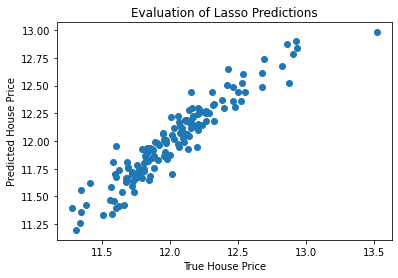

In [ ]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, price_pipe.predict(X_test))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Lasso Predictions')

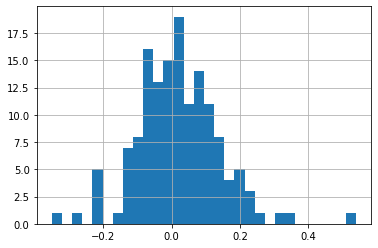

In [ ]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(price_pipe.predict(X_test))

errors = y_test - preds
errors.hist(bins=30)
plt.show()

In [ ]:
# now let's save the model pipeline

joblib.dump(price_pipe, path_to_save_the_model_pipe+'price_pipe.joblib') 

['/content/drive/MyDrive/Colab Notebooks/Training_projects/Houses_sales/price_pipe.joblib']

# Scoring new data

## Data Preprocessing

In [ ]:
# load the unseen / new dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Training_projects/Houses_sales/datasets/test.csv')

In [ ]:
data.drop('Id', axis=1, inplace=True)

data['MSSubClass'] = data['MSSubClass'].astype('O')

data.shape

(1459, 79)

In [ ]:
data = data.loc[ :, FEATURES]

data.head()

,MSSubClass,MSZoning,LotFrontage,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MoSold,SaleType,SaleCondition,YrSold
0,20,RH,80.0,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,Gable,CompShg,VinylSd,0.0,TA,CBlock,TA,TA,No,468.0,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,896,0.0,0.0,1,0,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,Y,140,0,0,0,120,0,NaN,MnPrv,6,WD,Normal,2010
1,20,RL,81.0,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,Hip,CompShg,Wd Sdng,108.0,TA,CBlock,TA,TA,No,923.0,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,1329,0.0,0.0,1,1,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,Y,393,36,0,0,0,0,NaN,NaN,6,WD,Normal,2010
2,60,RL,74.0,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1998,Gable,CompShg,VinylSd,0.0,TA,PConc,Gd,TA,No,791.0,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,1629,0.0,0.0,2,1,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,Y,212,34,0,0,0,0,NaN,MnPrv,3,WD,Normal,2010
3,60,RL,78.0,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,Gable,CompShg,VinylSd,20.0,TA,PConc,TA,TA,No,602.0,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,1604,0.0,0.0,2,1,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,Y,360,36,0,0,0,0,NaN,NaN,6,WD,Normal,2010
4,120,RL,43.0,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,Gable,CompShg,HdBoard,0.0,Gd,PConc,Gd,TA,No,263.0,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,1280,0.0,0.0,2,0,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,Y,0,82,0,0,144,0,NaN,NaN,1,WD,Normal,2010


In [ ]:
new_vars_with_na = [
    var for var in FEATURES
    if var not in CATEGORICAL_VARS_WITH_NA_FREQUENT +
    CATEGORICAL_VARS_WITH_NA_MISSING +
    NUMERICAL_VARS_WITH_NA
    and data[var].isnull().sum() > 0]

new_vars_with_na

['MSZoning',
 'Utilities',
 'Exterior1st',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea',
 'SaleType']

In [ ]:
data[new_vars_with_na].head()

,MSZoning,Utilities,Exterior1st,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,KitchenQual,Functional,GarageCars,GarageArea,SaleType
0,RH,AllPub,VinylSd,468.0,144.0,270.0,882.0,0.0,0.0,TA,Typ,1.0,730.0,WD
1,RL,AllPub,Wd Sdng,923.0,0.0,406.0,1329.0,0.0,0.0,Gd,Typ,1.0,312.0,WD
2,RL,AllPub,VinylSd,791.0,0.0,137.0,928.0,0.0,0.0,TA,Typ,2.0,482.0,WD
3,RL,AllPub,VinylSd,602.0,0.0,324.0,926.0,0.0,0.0,Gd,Typ,2.0,470.0,WD
4,RL,AllPub,HdBoard,263.0,0.0,1017.0,1280.0,0.0,0.0,Gd,Typ,2.0,506.0,WD


In [ ]:
data[new_vars_with_na].isnull().mean()

MSZoning        0.002742
Utilities       0.001371
Exterior1st     0.000685
BsmtFinSF1      0.000685
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
KitchenQual     0.000685
Functional      0.001371
GarageCars      0.000685
GarageArea      0.000685
SaleType        0.000685
dtype: float64

In [ ]:
data.dropna(subset=new_vars_with_na, inplace=True)

print(data.shape)

(1447, 67)


## Test the model

In [ ]:
# make predictions for new test set
new_pred = price_pipe.predict(data)

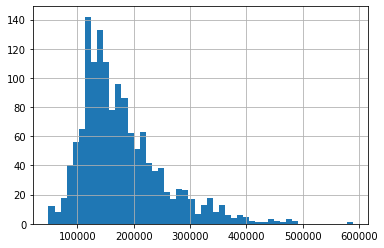

In [ ]:
# let's plot the predicted sale prices
pd.Series(np.exp(new_pred)).hist(bins=50)